# Cleaning anomalies in time series per region slug



## Load  libraries

In [1]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path
home = str(Path.home())

import sys
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages']
sys.prefix = '/home/soniame/.conda/envs/norm_env'

from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

from copy import deepcopy
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
import yaml
import matplotlib.pyplot as plt 
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

# Plotting
import plotly
import plotly.graph_objs as go
import cufflinks as cf
plotly.offline.init_notebook_mode(connected=True)

def iplottitle(title, width=40):
    return '<br>'.join(textwrap.wrap(title, width))
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format
p9.theme_set(p9.theme_linedraw()) # default theme

# Setting cufflinks
import textwrap
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import yaml
from jinja2 import Template
cf.themes.THEMES['custom'] = yaml.load(open('cufflinks_template.yaml', 'r'))

# Manipulation 
from siuba import *

# Outliers
from adtk.data import validate_series
from adtk.transformer import DoubleRollingAggregate
from adtk.visualization import plot
from adtk.pipe import Pipeline
from adtk.detector import QuantileAD
from adtk.transformer import ClassicSeasonalDecomposition

## Load data

### dahsboard data

In [2]:
from src import utils

conn = utils.connect_athena(path='../configs/athena.yaml')
df = pd.read_sql_query("""
select 
    *,
    date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
from spd_sdv_waze_corona.prod_daily_daily_index
where region_slug in ('country_mexico', 'country_brazil', 
    'mexicocity', 'riodejaneiro', 'saopaulo', 'torreon')
""", conn)

In [3]:
df.head(3)

,last_updated_utc,region_slug,region_name,country_name,country_iso_code,country_idb_code,region_type,population,timezone,year,month,day,dow,observed,expected_2020,ratio_20,tcp,dashboard,region_shapefile_wkt,date
0,2021-03-15 10:53:07.128,mexicocity,Ciudad de México,Mexico,MX,ME,city,22381714,America/Mexico_City,2020,5,14,4,30235297,196096743.0,0.154186,-84.581438,TRUE,Polygon ((-99.22541498771096258 19.79958548078...,2020-05-14
1,2021-03-15 10:53:07.128,mexicocity,Ciudad de México,Mexico,MX,ME,city,22381714,America/Mexico_City,2020,7,2,4,75902926,196096743.0,0.387069,-61.293123,TRUE,Polygon ((-99.22541498771096258 19.79958548078...,2020-07-02
2,2021-03-15 10:53:07.128,mexicocity,Ciudad de México,Mexico,MX,ME,city,22381714,America/Mexico_City,2020,3,19,4,114956189,196096743.0,0.586222,-41.377818,TRUE,Polygon ((-99.22541498771096258 19.79958548078...,2020-03-19


## Process creation

In [4]:
import numpy as np
import pandas as pd
from functools import reduce
#import logger from loguru
from datetime import datetime, timedelta
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import LevelShiftAD, PersistAD, GeneralizedESDTestAD, SeasonalAD, AutoregressionAD
from tsmoothie.smoother import DecomposeSmoother


### Functions

In [131]:
def _validate_series(df, column_name):
    """
    A function to validate series
    
    Parameters
        ----------
        df : data frame 
            Data frame with column to validare. The data frame requires
            columns region_slug and date to be sorted. Date is defined as
            the index.
        column_name : str
            Name of the column to validate
    """

    print("... validating ...")
    y_df = df.sort_values(['region_slug', 'date'])[['date', column_name]].set_index('date')
    s = validate_series(y_df)
    
    return s

#### Shift functions

In [130]:
### Shift functions

def _level_shift_detection(s, c_param = 6.0, window_param = 14, print_plot = False):
    """
    Level shift or change point detection. This function uses the function 
    LevelShiftAD from ADTK library.
    
    Parameters
    ----------
        s : validated serie object 
            Description
        c_param : dbl, default 6.0
            Description
        window_param : int, default 14
            Description
        print_plot: bool, default True
            Description
    """
    
    print("... detecting shift ...")
    level_shift_ad = LevelShiftAD(c=c_param, side='both', window=window_param)
    anomalies = level_shift_ad.fit_detect(s)
    
    if print_plot:
        plot(s, anomaly=anomalies, anomaly_color='red')
    
    return anomalies

def _shifted_ts(shift, column_name, df):
    # shift ts level
    
    print("... centering shift ...")
    # shift level happening
    shift_init = shift[shift[column_name] == 1].date.min()
    
    # a two weeks both sided window
    shift_wdw_init = shift_init - timedelta(days=14)
    shift_wdw_end  = shift_init + timedelta(days=14)

    # level centered
    center_point = ((df[(df['date'] >  shift_wdw_init) & 
                        (df['date'] <= shift_init)].observed.mean()) -
                    (df[(df['date'] >  shift_init) & 
                        (df['date'] <= shift_wdw_end)].observed.mean())
                   )

    # change print to logger
    print(center_point)

    df['obs_shifted'] = df[column_name]
    df['obs_shifted'][(df['date'] > shift_init)] = \
        ((df[column_name][(df['date'] > shift_init)]) + 
          center_point)

    return df, shift_init
    
    
def _shifted_adtk_ts(s, column_name, agg="std", window=(3,3), diff="l2", print_plot=True):
    # shift ts level
    
    s_transformed = DoubleRollingAggregate(
        agg=agg,
        window=window,
        diff=diff).transform(s).rename(columns={column_name:'adtk_shift'})
    
    if print_plot:
        plot(pd.concat([s, s_transformed], axis=1))
        
    return s_transformed
                

#### Outlier functions

In [79]:
### Outlier functions
def _outlier_persist_ad(s, c_param = 4, window_param = 14):
    persist_ad = PersistAD(c=c_param, side='both', window = window_param)
    #persist_ad.window = 14
    anomalies = persist_ad.fit_detect(s)

    return(anomalies)

def _outlier_gesdt_ad(s, alpha_param = 0.3, window_param = 14):
    esd_ad = GeneralizedESDTestAD(alpha=alpha_param)
    anomalies = persist_ad.fit_detect(s)

    return(anomalies)

def _outlier_seasonal_ad(s, c_param = 3.0, window_param = 14):
    seasonal_ad = SeasonalAD(c=c_param, side="both")
    anomalies = seasonal_ad.fit_detect(s)

    return(anomalies)

def _outlier_autregr_ad(s, c_param = 3.0, n_steps_param = 4, step_size_param=7):
    autoregression_ad = AutoregressionAD(n_steps=n_steps_param, step_size=step_size_param, c=c_param)
    anomalies = autoregression_ad.fit_detect(s)
    
    return(anomalies)

def _anomalies_detector(s):
    anomalies = _outlier_persist_ad(s) \
        .rename(columns={'obs_shifted':'anomaly_persist'}) \
        .reset_index() \
        .merge(_outlier_seasonal_ad(s) \
               .rename(columns={'obs_shifted':'anomaly_seasonal'}) \
               .reset_index()) \
        .merge(_outlier_autregr_ad(s) \
               .rename(columns={'obs_shifted':'anomaly_autor'}) \
               .reset_index()) \
        .fillna(0)
    #plot(s, anomalies, ts_linewidth=1)
    anomalies['anomaly_sum'] = \
        (anomalies['anomaly_persist']) + \
        (anomalies['anomaly_seasonal'] == True) +  \
        (anomalies['anomaly_autor'])
    anomalies.head(2)
    
    return(anomalies[anomalies.anomaly_sum > 0])


#### Imputation functions

In [80]:
### Imputation functions
def _decompose_lowess(variable_smooth, missing_values):
    # operate smoothing
    # variable_smooth = (df_imputate.obs_shifted)
    smoother = DecomposeSmoother(smooth_type='lowess', periods=7,
                             smooth_fraction=0.2)
    smoother.smooth(variable_smooth)

    result = variable_smooth
    smooth_result = smoother.smooth_data[0]
    result[missing_values] = smooth_result[missing_values]
    
    return result


#### Process functions

In [81]:
### Process functions

def _shift_level(df, observed_variable, c_param=6.0):

    # 1. Shift level
    df['obs_shifted'] = df[observed_variable]
    run_param = True
    dates_list = list()
    shift_cnt = 0

    while run_param:

        # detect shifts of level in the data
        #c_param = c_param
        s = _validate_series(df, column_name='obs_shifted')
        shift = _level_shift_detection(s, c_param = 6.0).reset_index()

        # it there are shifts, rescaled the data
        # only run if there're more shifts
        run_param = sum(shift['obs_shifted'] == 1)>0 
        print(run_param)
        if run_param:
            shift_cnt=+1
            df_shift, date_shift = _shifted_ts(shift, 
                                               column_name='obs_shifted', 
                                               df=df)
            dates_list.append(date_shift)

    if shift_cnt == 0:
        df_shift = df
        
    print('Shifts found: ' + str(shift_cnt))  
    print(dates_list)
    #print(df_shift[['date', 'observed', 'obs_shifted']])
    print(df_shift.shape)
    print(_plot_levelshift(df_shift, observed_variable))
    
    return df_shift

# 2. Find anomalies
def _find_anomalies(df_shift, anomaly_vote_minimun, column_name= 'obs_shifted', print_plot=True):

    # validate series
    s = _validate_series(df_shift, column_name)
    
    # join anomialies detector
    df_anomaly = df_shift.merge(_anomalies_detector(s), how = 'left')
    anomalies_cnt = sum(df_anomaly.anomaly_sum >= anomaly_vote_minimun)
    print('Anomalies found: ' + str(anomalies_cnt))  
    print(df_anomaly.shape)
    if print_plot:
        print(_plot_anomalies(df_anomaly))
    
    return(df_anomaly)

# 3. Impute anomalies
def _impute_anomalies(df_anomaly, anomaly_vote_minimun, print_plot = True):
    
    df_anomaly['obs_missing'] = df_anomaly['obs_shifted']
    df_anomaly['obs_missing'][df_anomaly.anomaly_sum >= anomaly_vote_minimun] = None
    df_anomaly['obs_missing'][df_anomaly['obs_missing'] < 0] = None
    df_impute = df_anomaly.set_index('date')

    df_impute =  df_impute \
        .assign(RollingMean=df_impute.obs_missing \
                    .fillna(df_impute.obs_missing \
                            .rolling(30, min_periods=1,) \
                            .mean()) ) \
        .assign(RollingMedian=df_impute.obs_missing \
                    .fillna(df_impute.obs_missing \
                            .rolling(30, min_periods=1,) \
                            .median()) ) \
        .assign(Polinomial=df_impute.obs_missing \
                    .interpolate(method='polynomial', order = 5)) \
        .assign(Loess=_decompose_lowess(df_impute.obs_shifted, 
                                        df_impute.obs_missing.isna())) 

    print(df_impute.shape)
    if print_plot:
        print(_plot_imputation(df_impute))
    
    return df_impute

In [63]:
### Plot functions
def _plot_levelshift(df_shift, observed_variable):
    gg = (p9.ggplot(data=df_shift,
               mapping=p9.aes(x='date', y=observed_variable)) 
        + p9.geom_line(size = 1) 
        + p9.geom_line(p9.aes(y = 'obs_shifted'), size = 1, color = "red") 
        + p9.labs(title='Level Shift')
         )
    return gg
    
def _plot_anomalies(df_anomaly):
    gg = (p9.ggplot(data=df_anomaly,
               mapping=p9.aes(x='date', y='obs_shifted')) 
        + p9.geom_line(size = 1) 
        + p9.geom_point(p9.aes(size = 'anomaly_sum', color ='anomaly_sum') )
        + p9.labs(title='Anomalies identification')
         )
    return gg
    
def _plot_imputation(df_imputate):
    gg = (p9.ggplot(data=df_imputate.reset_index(),
           mapping=p9.aes(x='date', y='obs_shifted')) 
        + p9.geom_line(color = 'gray') 
        + p9.geom_line(p9.aes(y = 'RollingMean'), color = "red", alpha = .4) 
        + p9.geom_line(p9.aes(y = 'Polinomial'), color = "green", alpha = .4) 
        + p9.geom_line(p9.aes(y = 'RollingMedian'), color = "blue", alpha = .4)
        + p9.geom_line(p9.aes(y = 'Loess'), color = "black") 
        + p9.labs(title='Imputation of anomalies')
         )    
    return gg

In [64]:
### run functions

def _run_cleaning(df, observed_variable, anomaly_vote_minimun):
    
    # 0. Parameter calculation
    
    # 1. Shift level
    df_shift   = _shift_level(df, observed_variable = 'observed', c_param=5.0)

    # 2. Find anomalies
    df_anomaly = _find_anomalies(df_shift, anomaly_vote_minimun = 1)

    # 3. Impute anomalies
    df_impute  = _impute_anomalies(df_anomaly, anomaly_vote_minimun = 1)
    
    return df_shift

In [23]:
df.date.min()

Timestamp('2020-03-09 00:00:00')

### Running one region slug

In [ ]:
#tt = _run_cleaning(df[df.region_slug == 'mexicocity'], 
#                 observed_variable = 'observed', 
#                 anomaly_vote_minimun = 1)

#(tt[['date', 'dow', 'observed', 'obs_shifted']][(tt.date >= '2020-07-07') & (tt.date <= '2020-07-30') | (tt.date >= '2020-12-07') & (tt.date <= '2021-01-10')]
# >> mutate(obs_shifted = _.obs_shifted/1000,
#          observed = _.observed/1000)
# >> arrange('date')
#).head()

### Running per region

In [ ]:
### run for each region
#for region in df.region_slug.unique():
#    print(f"... region_slug {region} ...")
#    
#    run_cleaning(df[df.region_slug == region], 
#                 observed_variable = 'observed', 
#                 anomaly_vote_minimun = 1)    

### Testing

In [145]:
region_slug = 'mexicocity'

In [87]:
df_cty = df[df.region_slug == region_slug]
observed_variable = 'observed'
df_cty['obs_shifted'] = df_cty[observed_variable]

In [132]:
df_anomaly = _find_anomalies(df_cty, anomaly_vote_minimun = 1, print_plot=False)
df_impute  = _impute_anomalies(df_anomaly, anomaly_vote_minimun = 1, print_plot=False).reset_index()
df_impute.head(3)

... validating ...
Anomalies found: 16
(371, 25)
(371, 29)


,date,last_updated_utc,region_slug,region_name,country_name,country_iso_code,country_idb_code,region_type,population,timezone,year,month,day,dow,observed,expected_2020,ratio_20,tcp,dashboard,region_shapefile_wkt,obs_shifted,anomaly_persist,anomaly_seasonal,anomaly_autor,anomaly_sum,obs_missing,RollingMean,RollingMedian,Polinomial,Loess
0,2020-05-14,2021-03-15 10:53:07.128,mexicocity,Ciudad de México,Mexico,MX,ME,city,22381714,America/Mexico_City,2020,5,14,4,30235297,196096743.0,0.154186,-84.581438,TRUE,Polygon ((-99.22541498771096258 19.79958548078...,30235297,NaN,NaN,NaN,NaN,30235297.0,30235297.0,30235297.0,30235297.0,30235297
1,2020-07-02,2021-03-15 10:53:07.128,mexicocity,Ciudad de México,Mexico,MX,ME,city,22381714,America/Mexico_City,2020,7,2,4,75902926,196096743.0,0.387069,-61.293123,TRUE,Polygon ((-99.22541498771096258 19.79958548078...,75902926,NaN,NaN,NaN,NaN,75902926.0,75902926.0,75902926.0,75902926.0,75902926
2,2020-03-19,2021-03-15 10:53:07.128,mexicocity,Ciudad de México,Mexico,MX,ME,city,22381714,America/Mexico_City,2020,3,19,4,114956189,196096743.0,0.586222,-41.377818,TRUE,Polygon ((-99.22541498771096258 19.79958548078...,114956189,NaN,NaN,NaN,NaN,114956189.0,114956189.0,114956189.0,114956189.0,114956189


... validating ...


[<AxesSubplot:>]

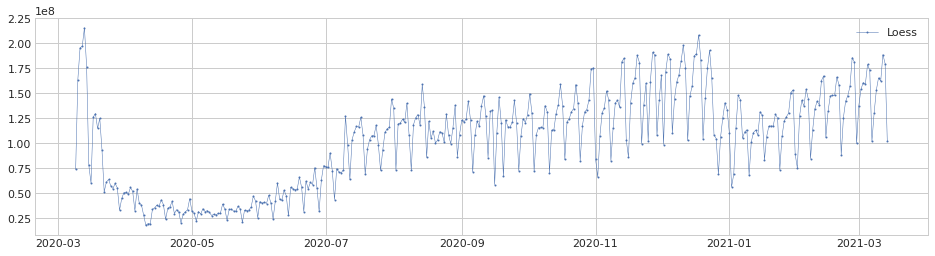

In [140]:
observed_variable = 'Loess'
s = _validate_series(df_impute, column_name='Loess')
plot(s)

In [159]:
c_region = pd.read_csv('/home/soniame/shared/spd-sdv-omitnik-waze/corona/raw/cities_c_iqr.csv') \
    .rename(columns={'city':'region_slug'})
c_param = c_region[c_region.region_slug == region_slug].c_low_p1

shift_l = list()
for cp in [ 1, 1.22, 2]:
    for wdw in [7, 14, 15, 16, 17, 18, 21]:    
        shift = _level_shift_detection(s, c_param = cp,
                                       window_param=wdw, 
                                       print_plot = False) \
                .rename(columns={observed_variable:f'shift_c{cp}_w{wdw}'})
        shift_l.append(shift)
len(shift_l)    
df_shift = reduce(lambda df1, df2: df1.merge(df2, on='date'), shift_l)
df_shift.shape
df_shift.head(3)

... detecting shift ...
... detecting shift ...
... detecting shift ...
... detecting shift ...
... detecting shift ...
... detecting shift ...
... detecting shift ...
... detecting shift ...
... detecting shift ...
... detecting shift ...
... detecting shift ...
... detecting shift ...
... detecting shift ...
... detecting shift ...
... detecting shift ...
... detecting shift ...
... detecting shift ...
... detecting shift ...
... detecting shift ...
... detecting shift ...
... detecting shift ...


,shift_c1_w7,shift_c1_w14,shift_c1_w15,shift_c1_w16,shift_c1_w17,shift_c1_w18,shift_c1_w21,shift_c1.22_w7,shift_c1.22_w14,shift_c1.22_w15,shift_c1.22_w16,shift_c1.22_w17,shift_c1.22_w18,shift_c1.22_w21,shift_c2_w7,shift_c2_w14,shift_c2_w15,shift_c2_w16,shift_c2_w17,shift_c2_w18,shift_c2_w21
date,,,,,,,,,,,,,,,,,,,,,
2020-03-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


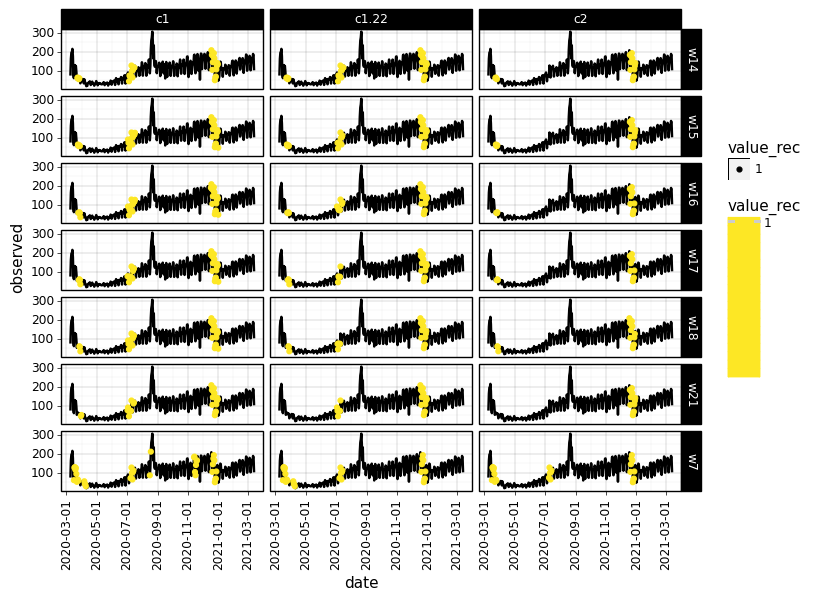

<ggplot: (8729454517037)>

In [160]:
tab = (df_shift.reset_index()
 >> gather('variable', 'value', -_.date)
 >> mutate(value_rec = _.value.replace( 0, np.nan))
 >> left_join(right = df_mx[['date', 'observed', 'dow']], on='date')
 >> mutate(observed = _.observed/1e6)
)
tab[['shift', 'cparam', 'window']] = tab['variable'].str.split('_',expand=True)
(p9.ggplot(tab, p9.aes(x ='date', y = 'observed'))
 + p9.geom_line(size = 1) 
 + p9.geom_point(p9.aes(size = 'value_rec', color = 'value_rec')) 
 + p9.facet_grid('window ~ cparam')
 + p9.scale_size_continuous(range=(1.5, 1.5)) 
 + p9.theme(axis_text_x=p9.element_text(angle=90),
            figure_size=(8, 6) )
)

In [143]:
(df_shift.reset_index()
 >> gather('variable', 'value', -_.date)
 >> filter(_.value == 1)
 >> group_by('variable')
 >> summarize(date_min = _.date.min())
 >> group_by('date_min')
 >> summarize(count = _.date_min.count())
 >> arrange('count')
)

,date_min,count
0,2020-03-23,3
1,2020-03-24,3
2,2020-03-25,3
3,2020-03-26,3
4,2020-03-27,3


In [144]:
df_shift.reset_index().head()
df_shift_sum = (df_shift.reset_index()
 >> gather('variable', 'value', -_.date)
 >> group_by('date')
 >> summarize(shift_sum = _.value.sum())
 >> filter(_.shift_sum > 0)
 >> arrange('date')
)
df_shift_sum.head()

,date,shift_sum
14,2020-03-23,3.0
15,2020-03-24,6.0
16,2020-03-25,9.0
17,2020-03-26,12.0
18,2020-03-27,14.0


In [ ]:
(df_mx.merge(df_shift_sum, on='date', how='left').siu_filter((_.date >= '2020-07-01') & (_.date <= '2020-07-26'))
 >> p9.ggplot(p9.aes(x='date', y='observed'))
 + p9.geom_line(size = 1) 
 + p9.geom_point(p9.aes(size = 'shift_sum', color ='shift_sum'), alpha = .8)
)

In [ ]:
shift_init = shift[shift[column_name] == 1].date.min()
    
# a two weeks both sided window
shift_wdw_init = shift_init - timedelta(days=14)
shift_wdw_end  = shift_init + timedelta(days=14)

# level centered
center_point = ((df[(df['date'] >  shift_wdw_init) & 
                    (df['date'] <= shift_init)].observed.mean()) -
                (df[(df['date'] >  shift_init) & 
                    (df['date'] <= shift_wdw_end)].observed.mean())
               )

# change print to logger
print(center_point)

df['obs_shifted'] = df[column_name]
df['obs_shifted'][(df['date'] > shift_init)] = \
    ((df[column_name][(df['date'] > shift_init)]) + 
      center_point)


In [ ]:
df_anomaly['obs_missing'] = df_anomaly['obs_shifted']
    df_anomaly['obs_missing'][df_anomaly.anomaly_sum >= anomaly_vote_minimun] = None
    df_anomaly['obs_missing'][df_anomaly['obs_missing'] < 0] = None
    df_impute = df_anomaly.set_index('date')

    df_impute =  df_impute \
        .assign(RollingMean=df_impute.obs_missing \
                    .fillna(df_impute.obs_missing \
                            .rolling(30, min_periods=1,) \
                            .mean()) ) \
        .assign(RollingMedian=df_impute.obs_missing \
                    .fillna(df_impute.obs_missing \
                            .rolling(30, min_periods=1,) \
                            .median()) ) \
        .assign(Polinomial=df_impute.obs_missing \
                    .interpolate(method='polynomial', order = 5)) \
        .assign(Loess=_decompose_lowess(df_impute.obs_shifted, 
                                        df_impute.obs_missing.isna()))